In [1]:
import json
import numpy as np
import pandas as pd
import xarray as xr
from xcube_smos.mldataset.newdgg import new_dgg
from xcube_smos.mldataset.l2cube import SmosL2Product
from xcube_smos.catalog import SmosDirectCatalog

In [2]:
dgg = new_dgg()

In [3]:
dgg_ds_0 = dgg.get_dataset(0)
dgg_ds_0

<xarray.Dataset>
Dimensions:  (lat: 4032, lon: 8192)
Coordinates:
  * lat      (lat) float64 88.57 88.53 88.48 88.44 ... -88.48 -88.53 -88.57
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Data variables:
    seqnum   (lat, lon) uint32 dask.array<chunksize=(4032, 8192), meta=np.ndarray>

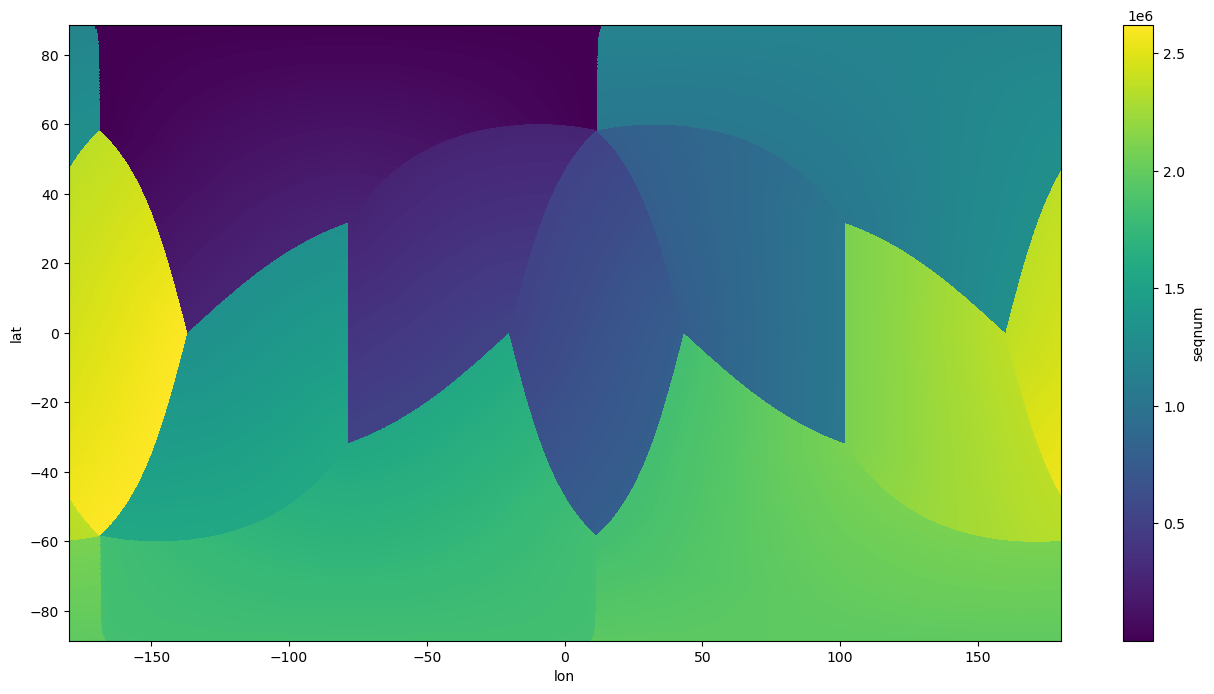

In [31]:
dgg_ds_0.seqnum.plot.imshow(figsize=(16, 8))

In [5]:
with open("creodias-credentials.json") as f:
    credentials = json.load(f)

In [6]:
catalog = SmosDirectCatalog(
    source_path="s3://EODATA",
    source_storage_options={
        "endpoint_url": "https://s3.cloudferro.com",
        "anon": False,
        **credentials,
    },
)

In [7]:
datasets = catalog.find_datasets("OS", ("2023-05-01", "2023-05-02"))

In [8]:
len(datasets)

13

In [9]:
datasets[0]

('EODATA/SMOS/L2OS/MIR_OSUDP2/2023/05/01/SM_OPER_MIR_OSUDP2_20230501T012809_20230501T022124_700_001_1/SM_OPER_MIR_OSUDP2_20230501T012809_20230501T022124_700_001_1.nc',
 '20230501012809',
 '20230501022124')

In [10]:
dataset_path, start_time, stop_time = datasets[0]
dataset_path

'EODATA/SMOS/L2OS/MIR_OSUDP2/2023/05/01/SM_OPER_MIR_OSUDP2_20230501T012809_20230501T022124_700_001_1/SM_OPER_MIR_OSUDP2_20230501T012809_20230501T022124_700_001_1.nc'

In [11]:
open_dataset = catalog.get_dataset_opener()
open_kwargs = catalog.get_dataset_opener_kwargs()

In [12]:
l2_dataset = open_dataset(dataset_path, **open_kwargs)
l2_dataset

<xarray.Dataset>
Dimensions:              (n_grid_points: 117970)
Dimensions without coordinates: n_grid_points
Data variables: (12/13)
    Dg_quality_SSS_corr  (n_grid_points) uint16 dask.array<chunksize=(117970,), meta=np.ndarray>
    Sigma_SSS_corr       (n_grid_points) float32 dask.array<chunksize=(117970,), meta=np.ndarray>
    Dg_RFI_X             (n_grid_points) uint16 dask.array<chunksize=(117970,), meta=np.ndarray>
    Dg_RFI_Y             (n_grid_points) uint16 dask.array<chunksize=(117970,), meta=np.ndarray>
    SSS_anom             (n_grid_points) float32 dask.array<chunksize=(117970,), meta=np.ndarray>
    Mean_acq_time        (n_grid_points) float32 dask.array<chunksize=(117970,), meta=np.ndarray>
    ...                   ...
    Dg_quality_SSS_anom  (n_grid_points) uint16 dask.array<chunksize=(117970,), meta=np.ndarray>
    X_swath              (n_grid_points) float32 dask.array<chunksize=(117970,), meta=np.ndarray>
    SSS_corr             (n_grid_points) float32 dask.array<chunksize=(117970,), meta=np.ndarray>
    Coast_distance       (n_grid_points) uint8 dask.array<chunksize=(117970,), meta=np.ndarray>
    Grid_Point_ID        (n_grid_points) uint32 dask.array<chunksize=(117970,), meta=np.ndarray>
    Sigma_SSS_anom       (n_grid_points) float32 dask.array<chunksize=(117970,), meta=np.ndarray>
Attributes:
    Precise_Validity_Start:  UTC=2023-05-01T01:28:08.370645
    Precise_Validity_Stop:   UTC=2023-05-01T02:21:24.015375
    Abs_Orbit_Start:         +70910
    Start_Time_ANX_T:        1320.166030
    Abs_Orbit_Stop:          +70910
    Stop_Time_ANX_T:         4515.810760
    UTC_at_ANX:              UTC=2023-05-01T01:06:08.204615
    Long_at_ANX:             +073.735974
    Ascending_Flag:          D
    Polarisation_Flag:       F

In [13]:
l2_product = SmosL2Product(dgg, l2_dataset)

In [14]:
mapped_l2_product = l2_product.get_mapped_s2_product(0)

In [15]:
var_data = mapped_l2_product.map_l2_var("Coast_distance")

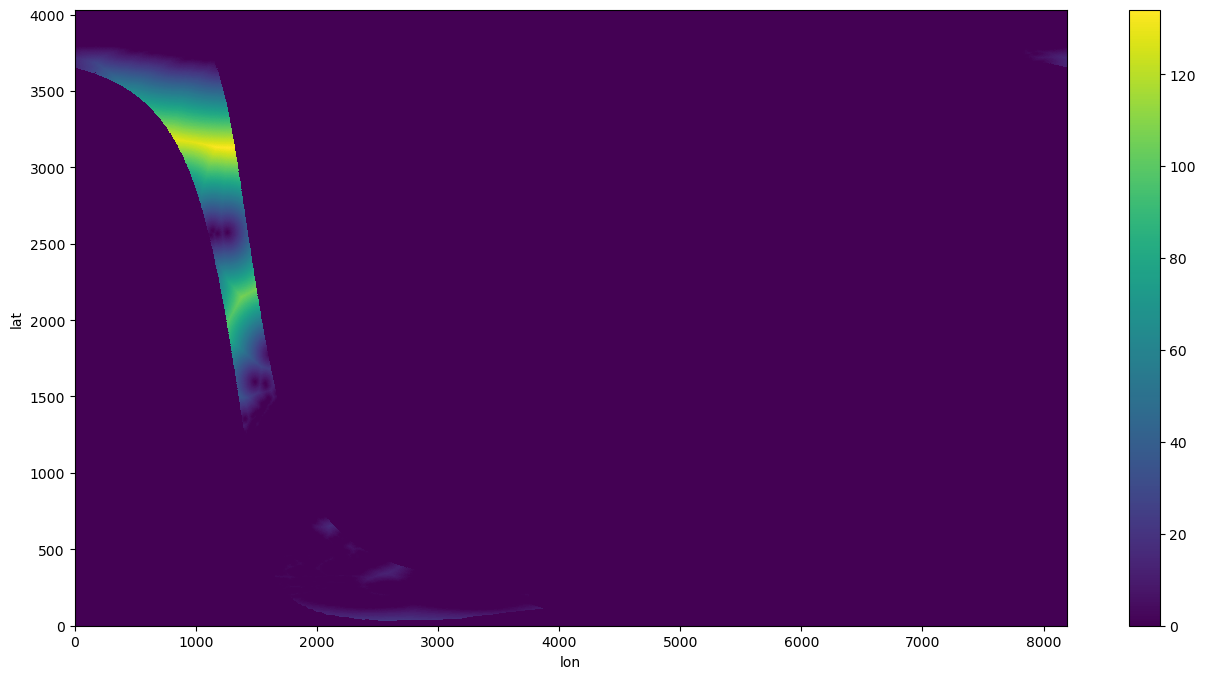

In [32]:
xr.DataArray(var_data, dims=("time", "lat", "lon")).isel(time=0).plot.imshow(
    figsize=(16, 8)
)

In [17]:
l2_dataset.Coast_distance.encoding

{'zlib': True,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': True,
 'complevel': 5,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (117970,),
 'source': 'C:\\Users\\norma\\AppData\\Local\\Temp\\xcube-smos-y4cwo8v8\\tmp9qq7w1p1.nc',
 'original_shape': (117970,),
 'dtype': dtype('uint8')}

In [18]:
l2_dataset.Coast_distance.attrs

{'_FillValue': 0,
 'scale_factor': 20.0,
 'scale_offset': 0.0,
 '_Unsigned': 'true'}

In [19]:
start, stop = pd.to_datetime([start_time, stop_time])

time_bounds_data = np.array([[start, stop]], dtype="datetime64[ns]")
time_bounds = xr.DataArray(time_bounds_data, dims=("time", "bounds"))

time_data = np.array([start + (stop - start) / 2])
time = xr.DataArray(time_data, dims=("time",))

In [20]:
h, w = dgg_ds_0.seqnum.shape
mapped_chunks = 1, h // 4, w // 4

mapped_data_vars = {}
for var_name, var in l2_dataset.data_vars.items():
    mapped_var_data = mapped_l2_product.map_l2_var(var_name)
    mapped_var = xr.DataArray(
        mapped_var_data, dims=("time", "lat", "lon"), attrs=var.attrs
    )
    mapped_var.encoding = {"dtype": var.dtype, "chunks": mapped_chunks}
    # print(var_name, mapped_var.encoding)
    mapped_data_vars[var_name] = mapped_var

In [21]:
mapped_l2_dataset = xr.Dataset(
    mapped_data_vars,
    coords={**dgg_ds_0.coords, "time": time, "time_bounds": time_bounds},
    attrs=l2_dataset.attrs,
)
mapped_l2_dataset

<xarray.Dataset>
Dimensions:              (lat: 4032, lon: 8192, time: 1, bounds: 2)
Coordinates:
  * lat                  (lat) float64 88.57 88.53 88.48 ... -88.53 -88.57
  * lon                  (lon) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
  * time                 (time) datetime64[ns] 2023-05-01T01:54:46.500000
    time_bounds          (time, bounds) datetime64[ns] 2023-05-01T01:28:09 20...
Dimensions without coordinates: bounds
Data variables: (12/13)
    Dg_quality_SSS_corr  (time, lat, lon) uint16 999 999 999 999 ... 999 999 999
    Sigma_SSS_corr       (time, lat, lon) float32 -999.0 -999.0 ... -999.0
    Dg_RFI_X             (time, lat, lon) uint16 64537 64537 ... 64537 64537
    Dg_RFI_Y             (time, lat, lon) uint16 64537 64537 ... 64537 64537
    SSS_anom             (time, lat, lon) float32 -999.0 -999.0 ... -999.0
    Mean_acq_time        (time, lat, lon) float32 -999.0 -999.0 ... -999.0
    ...                   ...
    Dg_quality_SSS_anom  (time, lat, lon) uint16 999 999 999 999 ... 999 999 999
    X_swath              (time, lat, lon) float32 -999.0 -999.0 ... -999.0
    SSS_corr             (time, lat, lon) float32 -999.0 -999.0 ... -999.0
    Coast_distance       (time, lat, lon) uint8 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    Grid_Point_ID        (time, lat, lon) uint32 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    Sigma_SSS_anom       (time, lat, lon) float32 -999.0 -999.0 ... -999.0
Attributes:
    Precise_Validity_Start:  UTC=2023-05-01T01:28:08.370645
    Precise_Validity_Stop:   UTC=2023-05-01T02:21:24.015375
    Abs_Orbit_Start:         +70910
    Start_Time_ANX_T:        1320.166030
    Abs_Orbit_Stop:          +70910
    Stop_Time_ANX_T:         4515.810760
    UTC_at_ANX:              UTC=2023-05-01T01:06:08.204615
    Long_at_ANX:             +073.735974
    Ascending_Flag:          D
    Polarisation_Flag:       F

In [22]:
mapped_l2_dataset.to_zarr("mapped_l2_dataset.zarr", mode="w", write_empty_chunks=False)

In [23]:
mapped_l2_dataset = xr.open_zarr("mapped_l2_dataset.zarr")

In [24]:
mapped_l2_dataset

<xarray.Dataset>
Dimensions:              (time: 1, lat: 4032, lon: 8192, bounds: 2)
Coordinates:
  * lat                  (lat) float64 88.57 88.53 88.48 ... -88.53 -88.57
  * lon                  (lon) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
  * time                 (time) datetime64[ns] 2023-05-01T01:54:46.500000
    time_bounds          (time, bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bounds
Data variables: (12/13)
    Coast_distance       (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    Dg_RFI_X             (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    Dg_RFI_Y             (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    Dg_chi2_corr         (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    Dg_quality_SSS_anom  (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    Dg_quality_SSS_corr  (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    ...                   ...
    Mean_acq_time        (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    SSS_anom             (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    SSS_corr             (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    Sigma_SSS_anom       (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    Sigma_SSS_corr       (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    X_swath              (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
Attributes:
    Abs_Orbit_Start:         +70910
    Abs_Orbit_Stop:          +70910
    Ascending_Flag:          D
    Long_at_ANX:             +073.735974
    Polarisation_Flag:       F
    Precise_Validity_Start:  UTC=2023-05-01T01:28:08.370645
    Precise_Validity_Stop:   UTC=2023-05-01T02:21:24.015375
    Start_Time_ANX_T:        1320.166030
    Stop_Time_ANX_T:         4515.810760
    UTC_at_ANX:              UTC=2023-05-01T01:06:08.204615

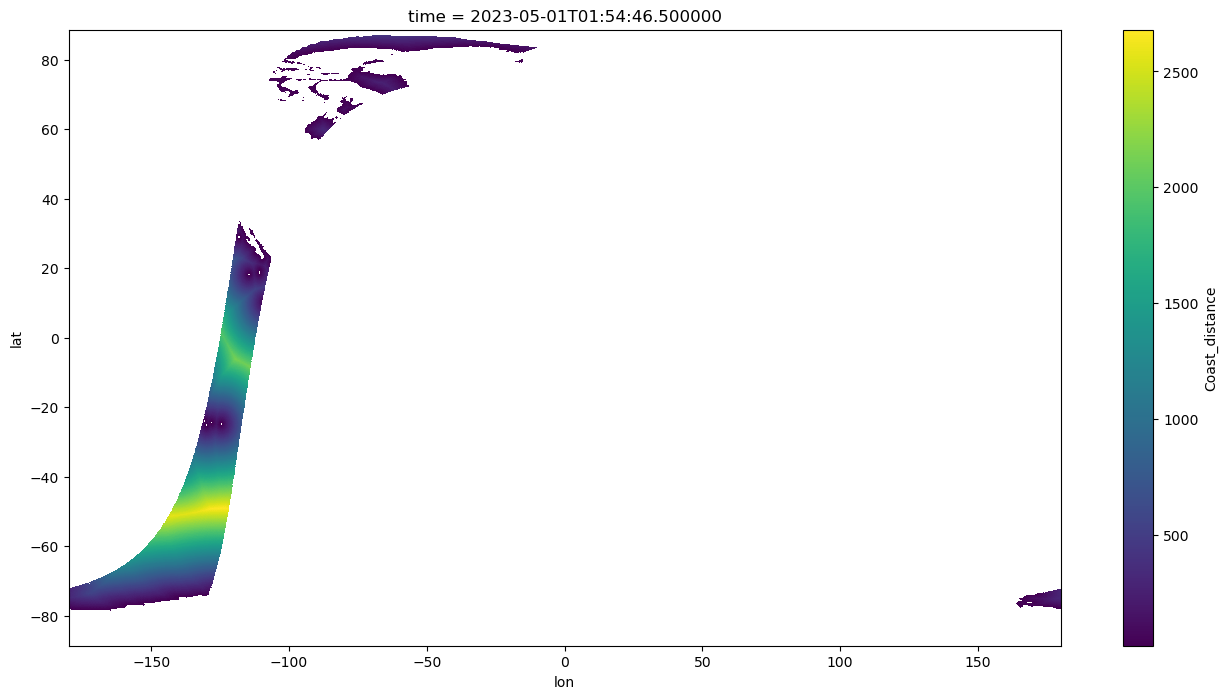

In [34]:
mapped_l2_dataset.Coast_distance.isel(time=0).plot.imshow(figsize=(16, 8))